<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Random Walks</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

numpy     1.18.1
pandas    1.0.1
json      2.0.9
scipy     1.4.1
watermark 2.0.2
autopep8  1.5
sklearn   0.22.1
Fri Mar 13 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ad81862f1ef6d671fcf7847b70b7356a814b054a


Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Coin flips

We start by defining a simple coin flipping function that we will use to simulate random walks

In [4]:
def flip_coin(n_coins, n_times, p=0.5):
    return 2*(np.random.random((n_times, n_coins))<p)-1

We can easily generate a quick plot of a few different trajectories

In [8]:
steps = flip_coin(3, 1000)

In [9]:
position = steps.cumsum(axis=0)

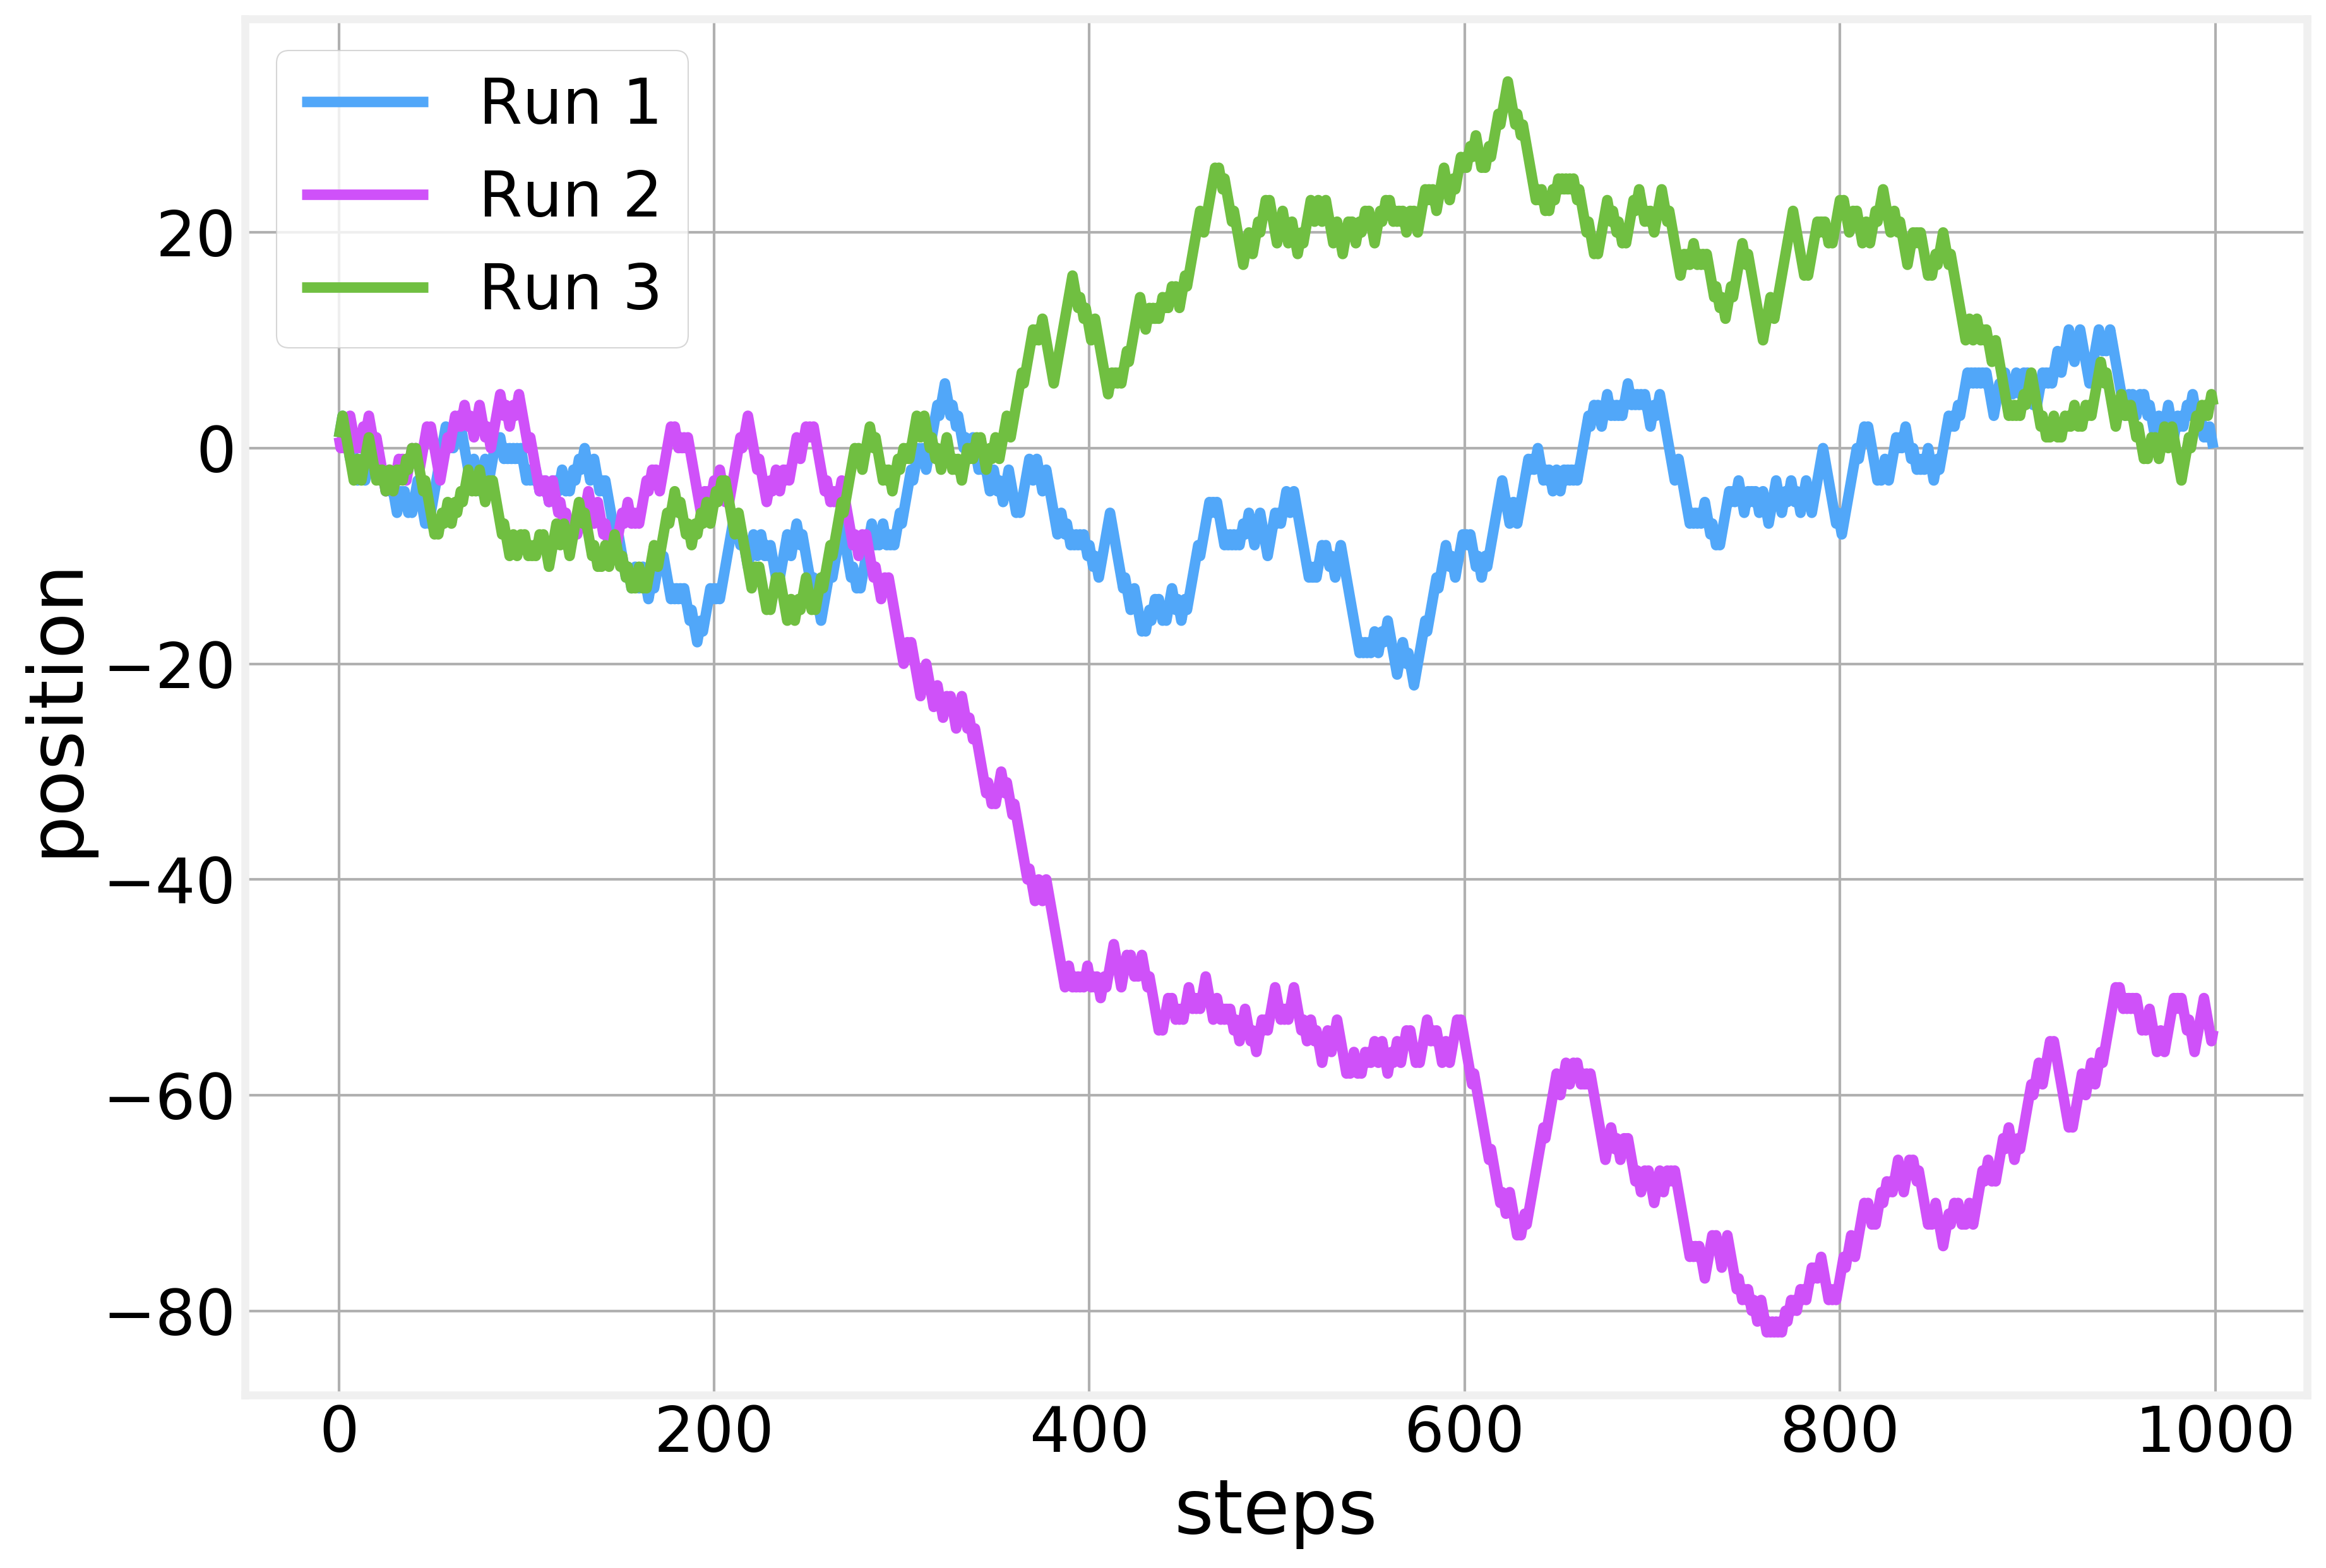

In [10]:
plt.plot(np.arange(1000), position.T[0], label='Run 1')
plt.plot(np.arange(1000), position.T[1], label='Run 2')
plt.plot(np.arange(1000), position.T[2], label='Run 3')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()

We can also see the individual steps (coin flips)

Text(0, 0.5, '$\\epsilon_i$')

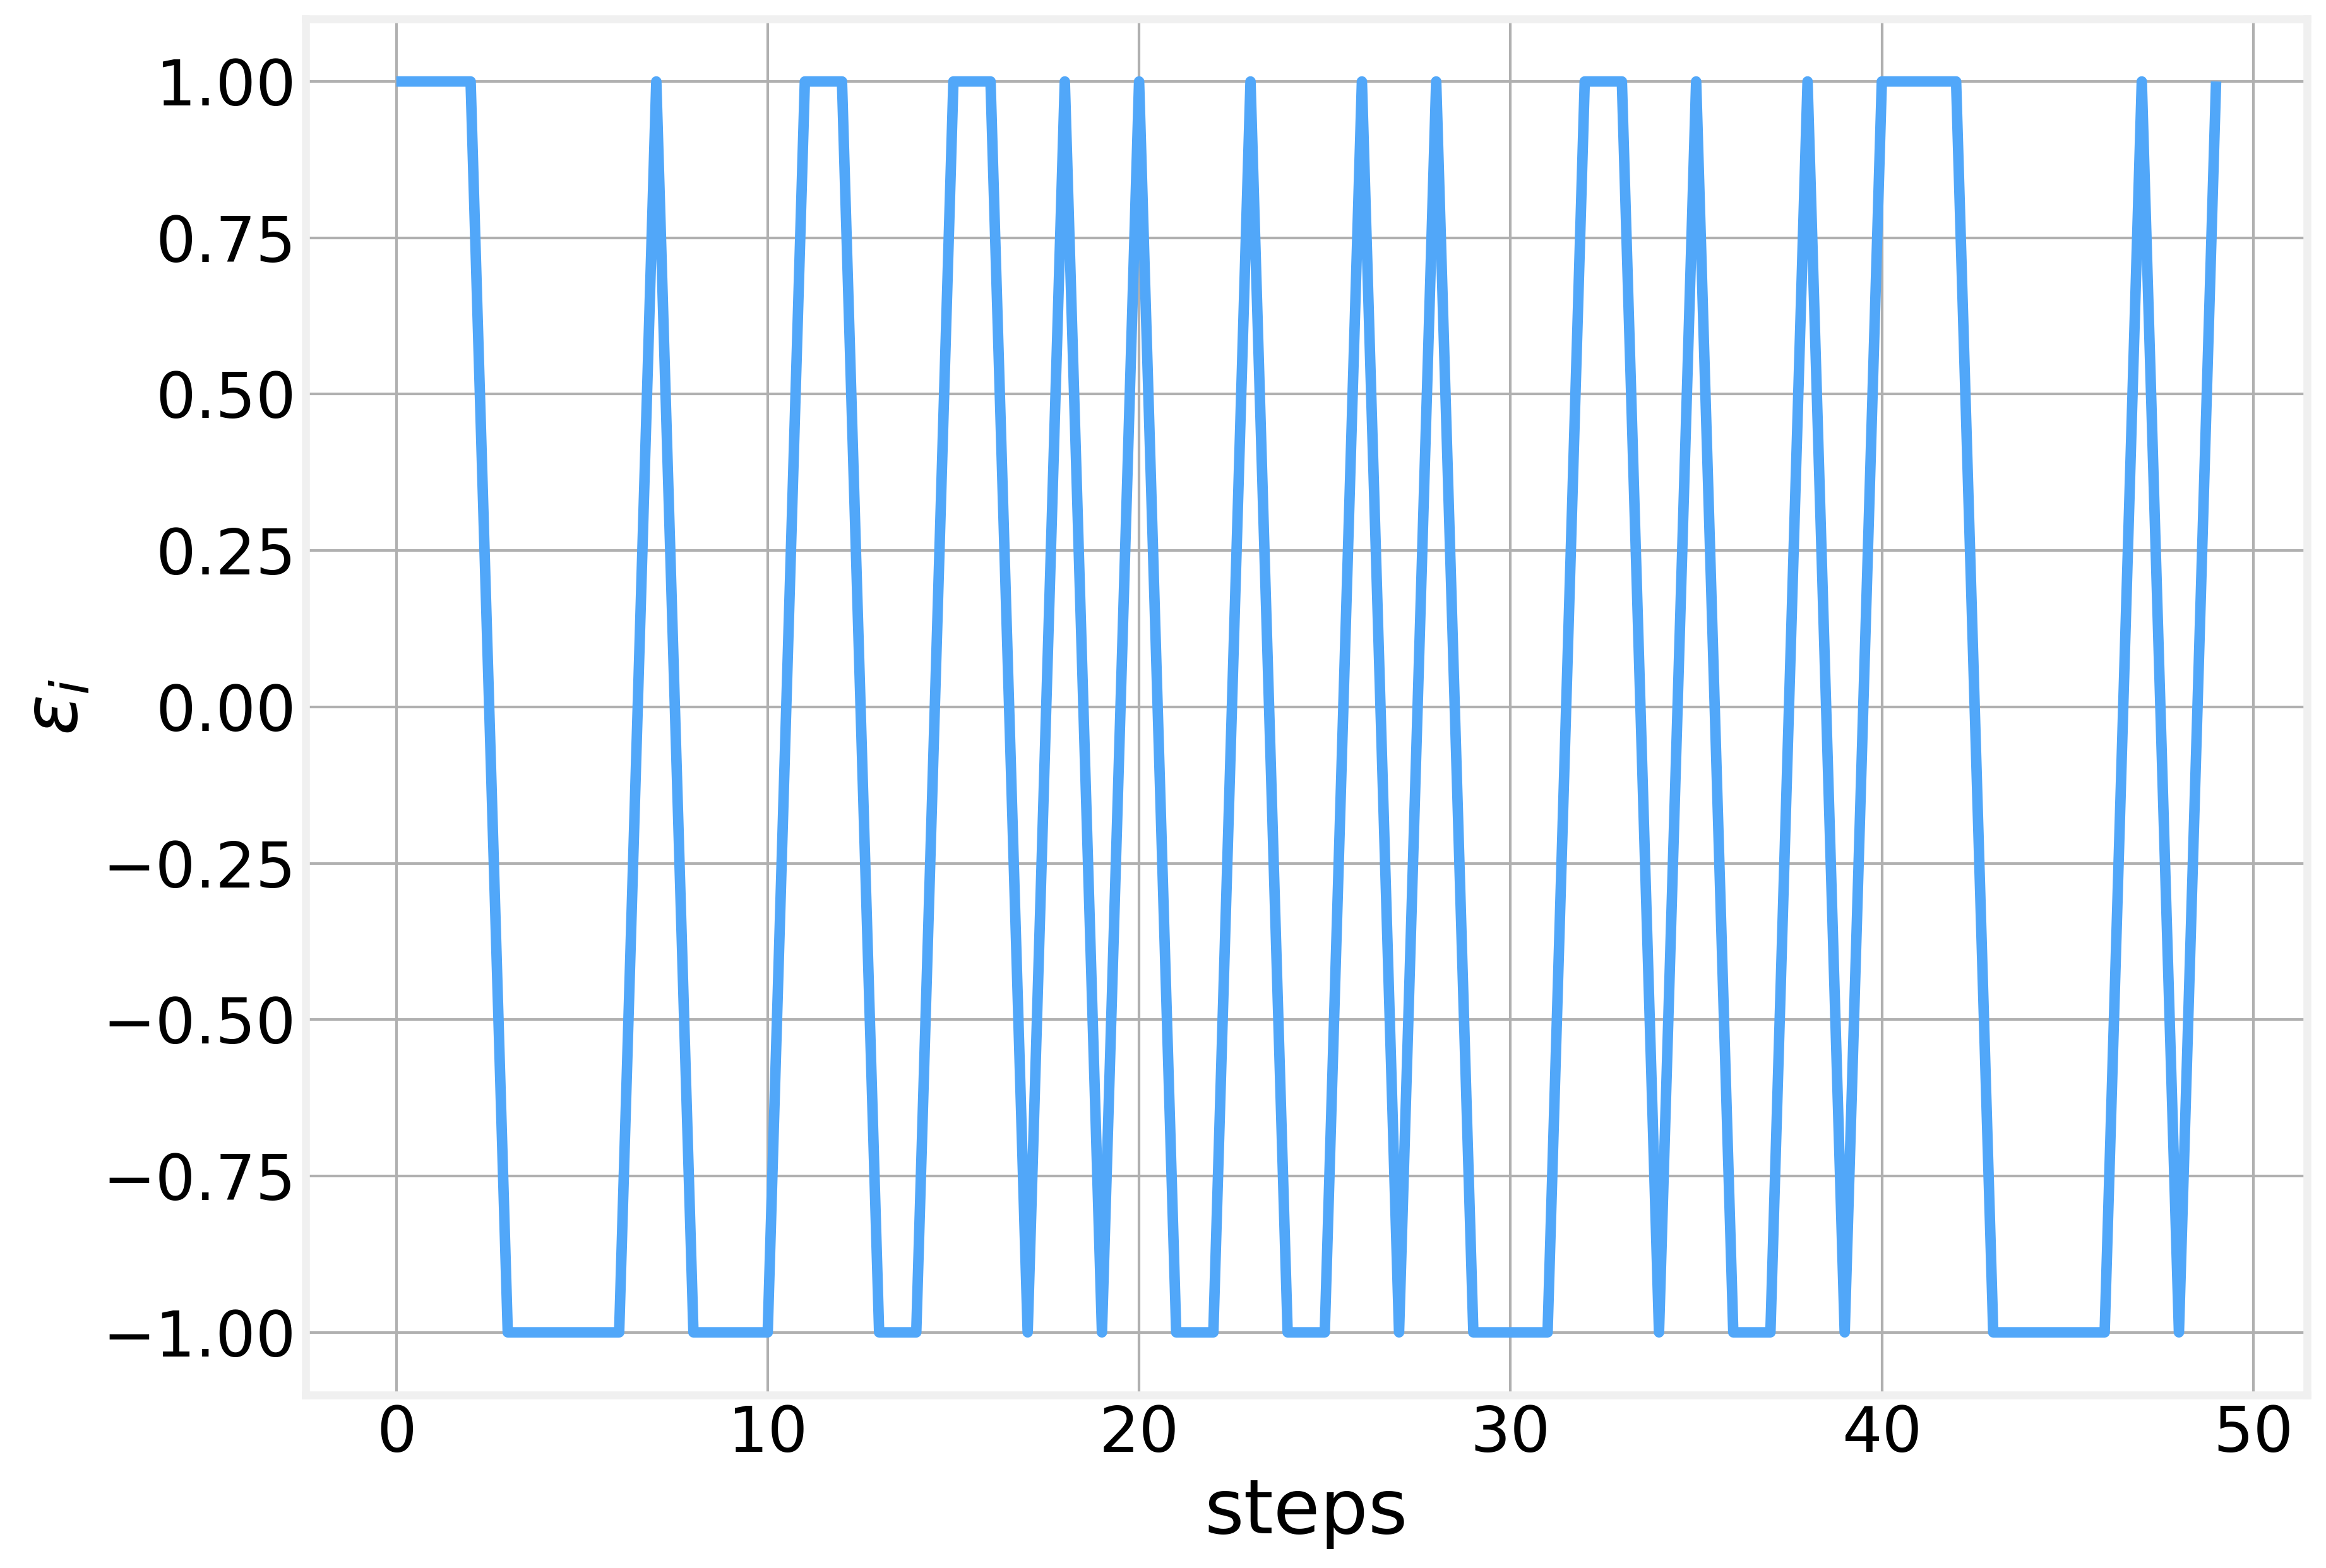

In [11]:
plt.plot(np.arange(50), steps.T[0][:50])
plt.xlabel('steps')
plt.ylabel(r'$\epsilon_i$')

We can easily see that the values are uncorrelated. We start by reloading the function of the Pearson Correlation function

In [12]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

And the functions for the autocorrelation function

In [13]:
def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

The confidence interval

In [14]:
def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

And our convenience plotting function

In [15]:
def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

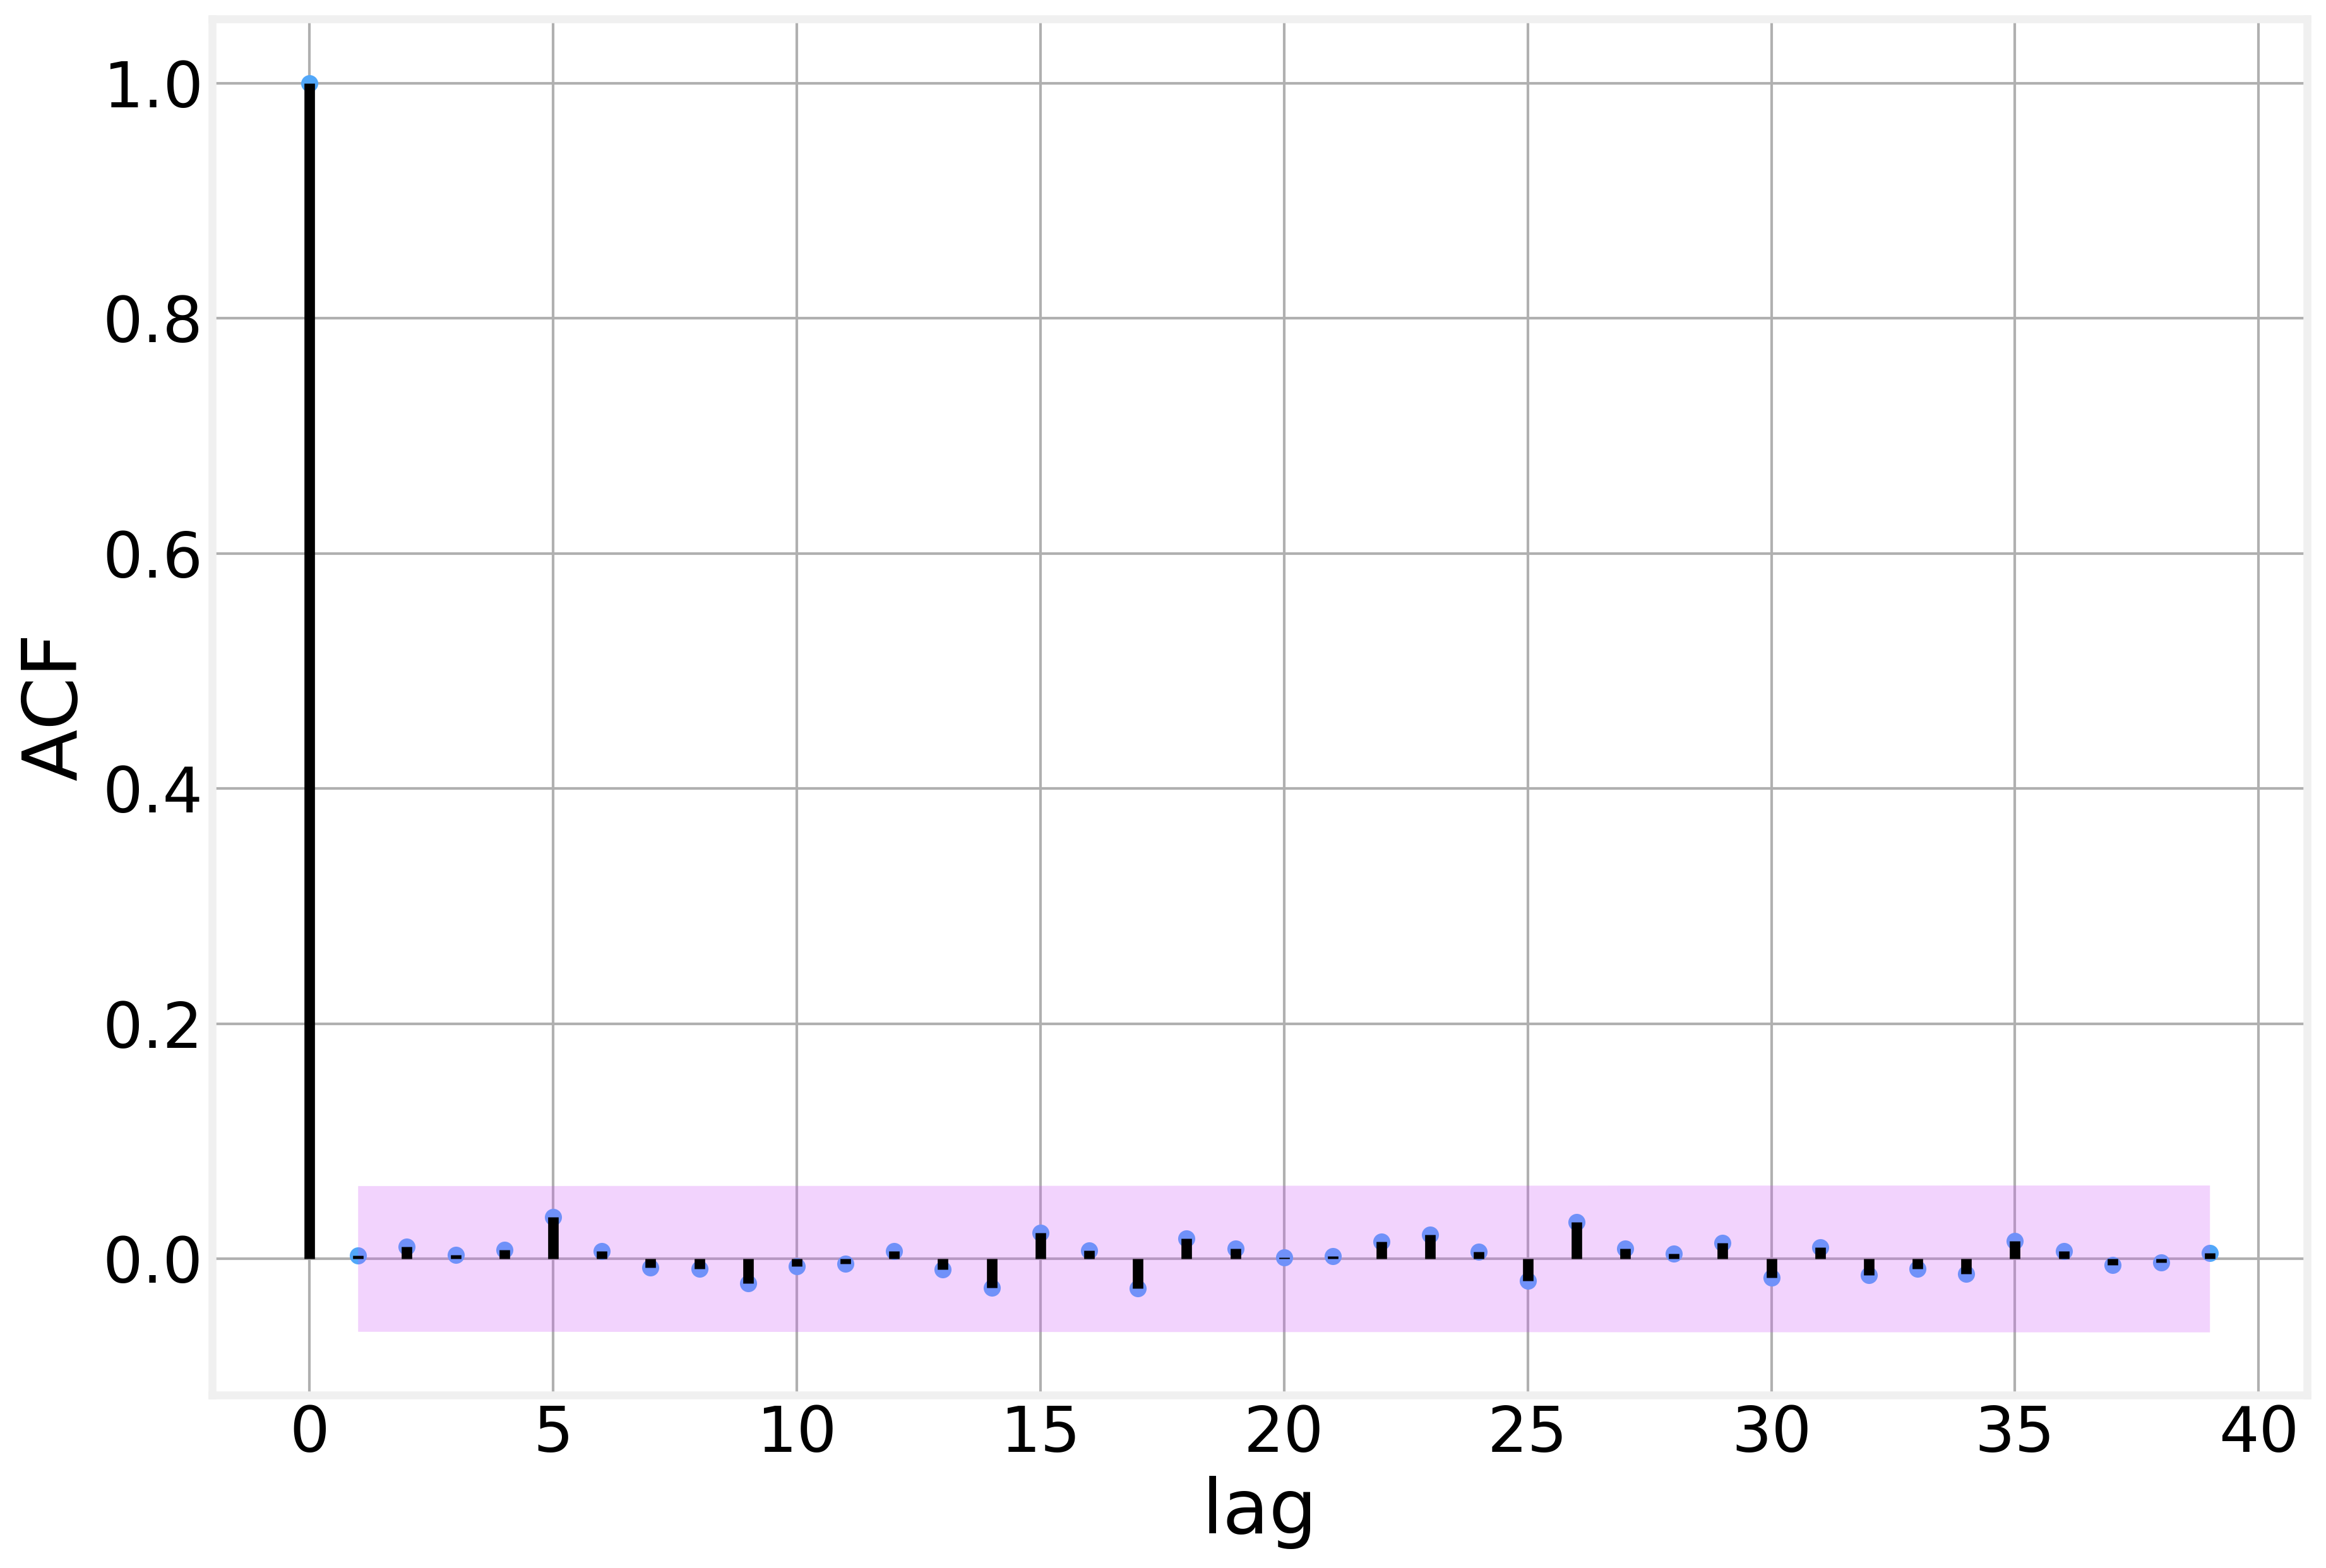

In [16]:
plot_acf(steps)

If the coin is biased then we can observe significant changes in the random walk

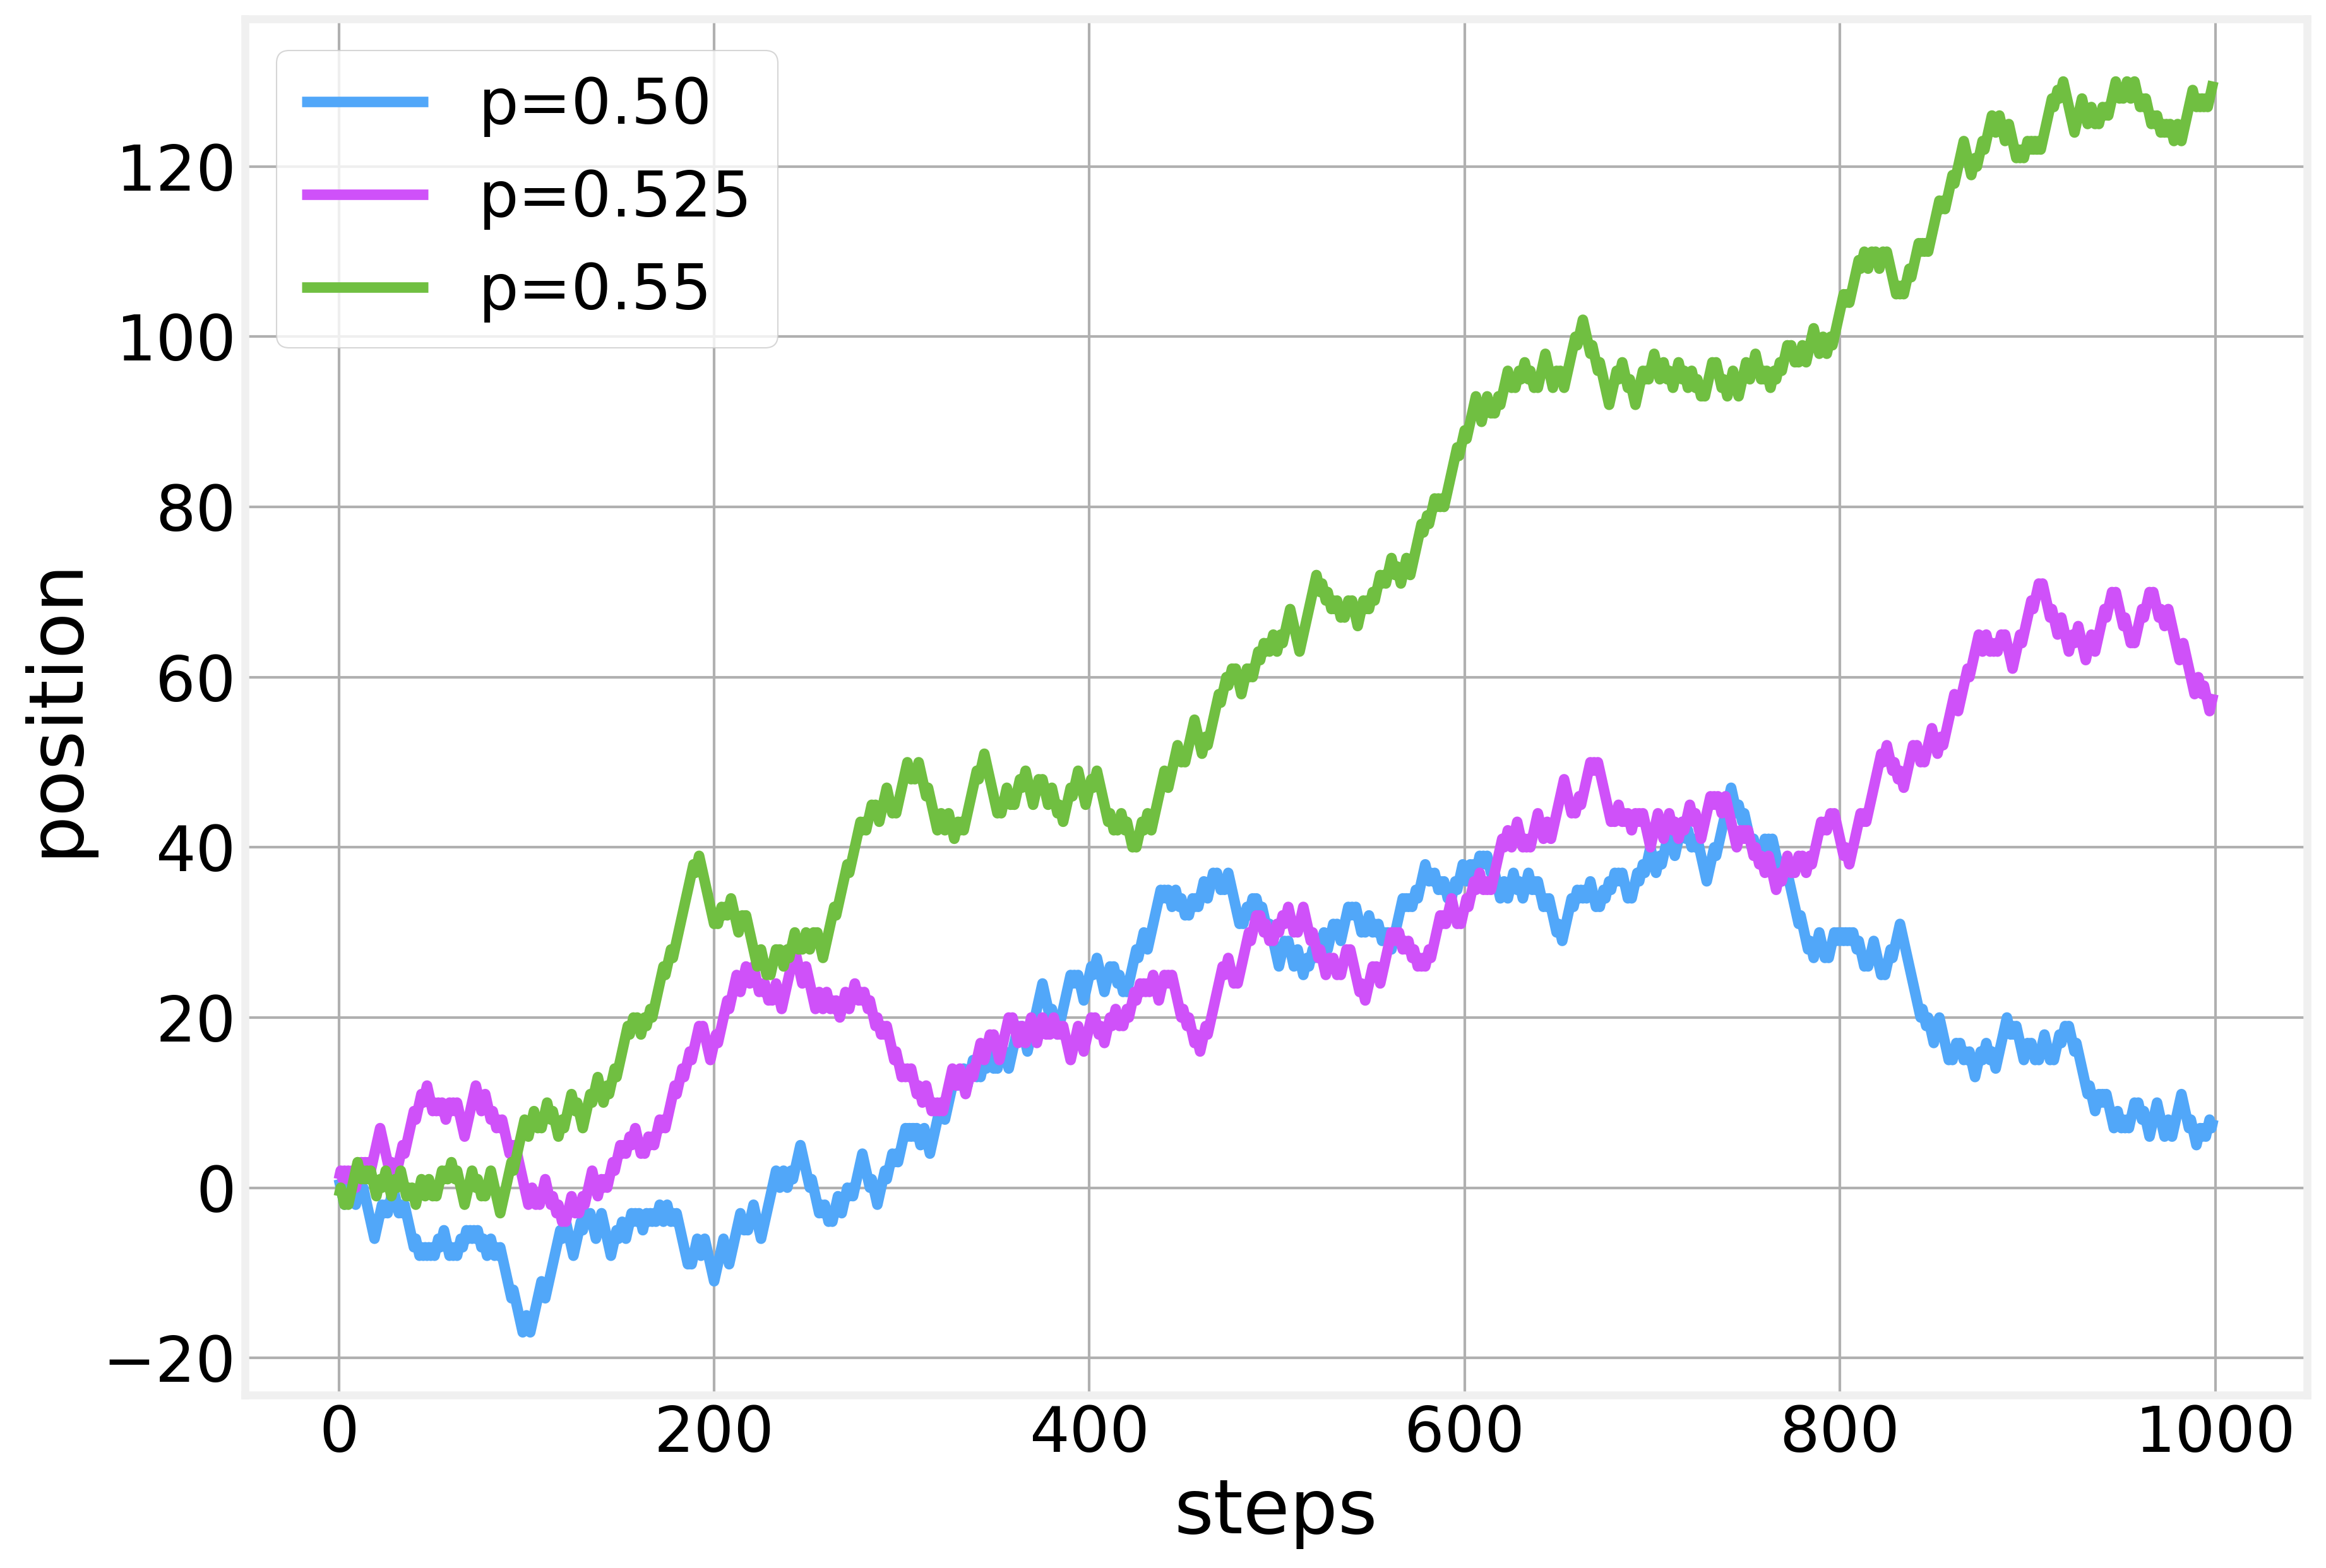

In [17]:
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.5).cumsum(), label='p=0.50')
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.525).cumsum(), label='p=0.525')
plt.plot(np.arange(1000), flip_coin(1, 1000, 0.55).cumsum(), label='p=0.55')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()

## Dicky-Fuller Test

The Dicky-Fuller test for stationarity relies on a statistical test for a unit root. We modify our random walk simulation to take the parameter $\rho$ into account

In [18]:
def position_rho(steps, rho):
    position = steps.astype('float').copy()

    for i in range(1, steps.shape[0]):
        position[i] = rho*position[i-1]+steps[i]
        
    return position

Now we can see that by varying $\rho$ we can interpolate between stationary and non-stationary behaviors

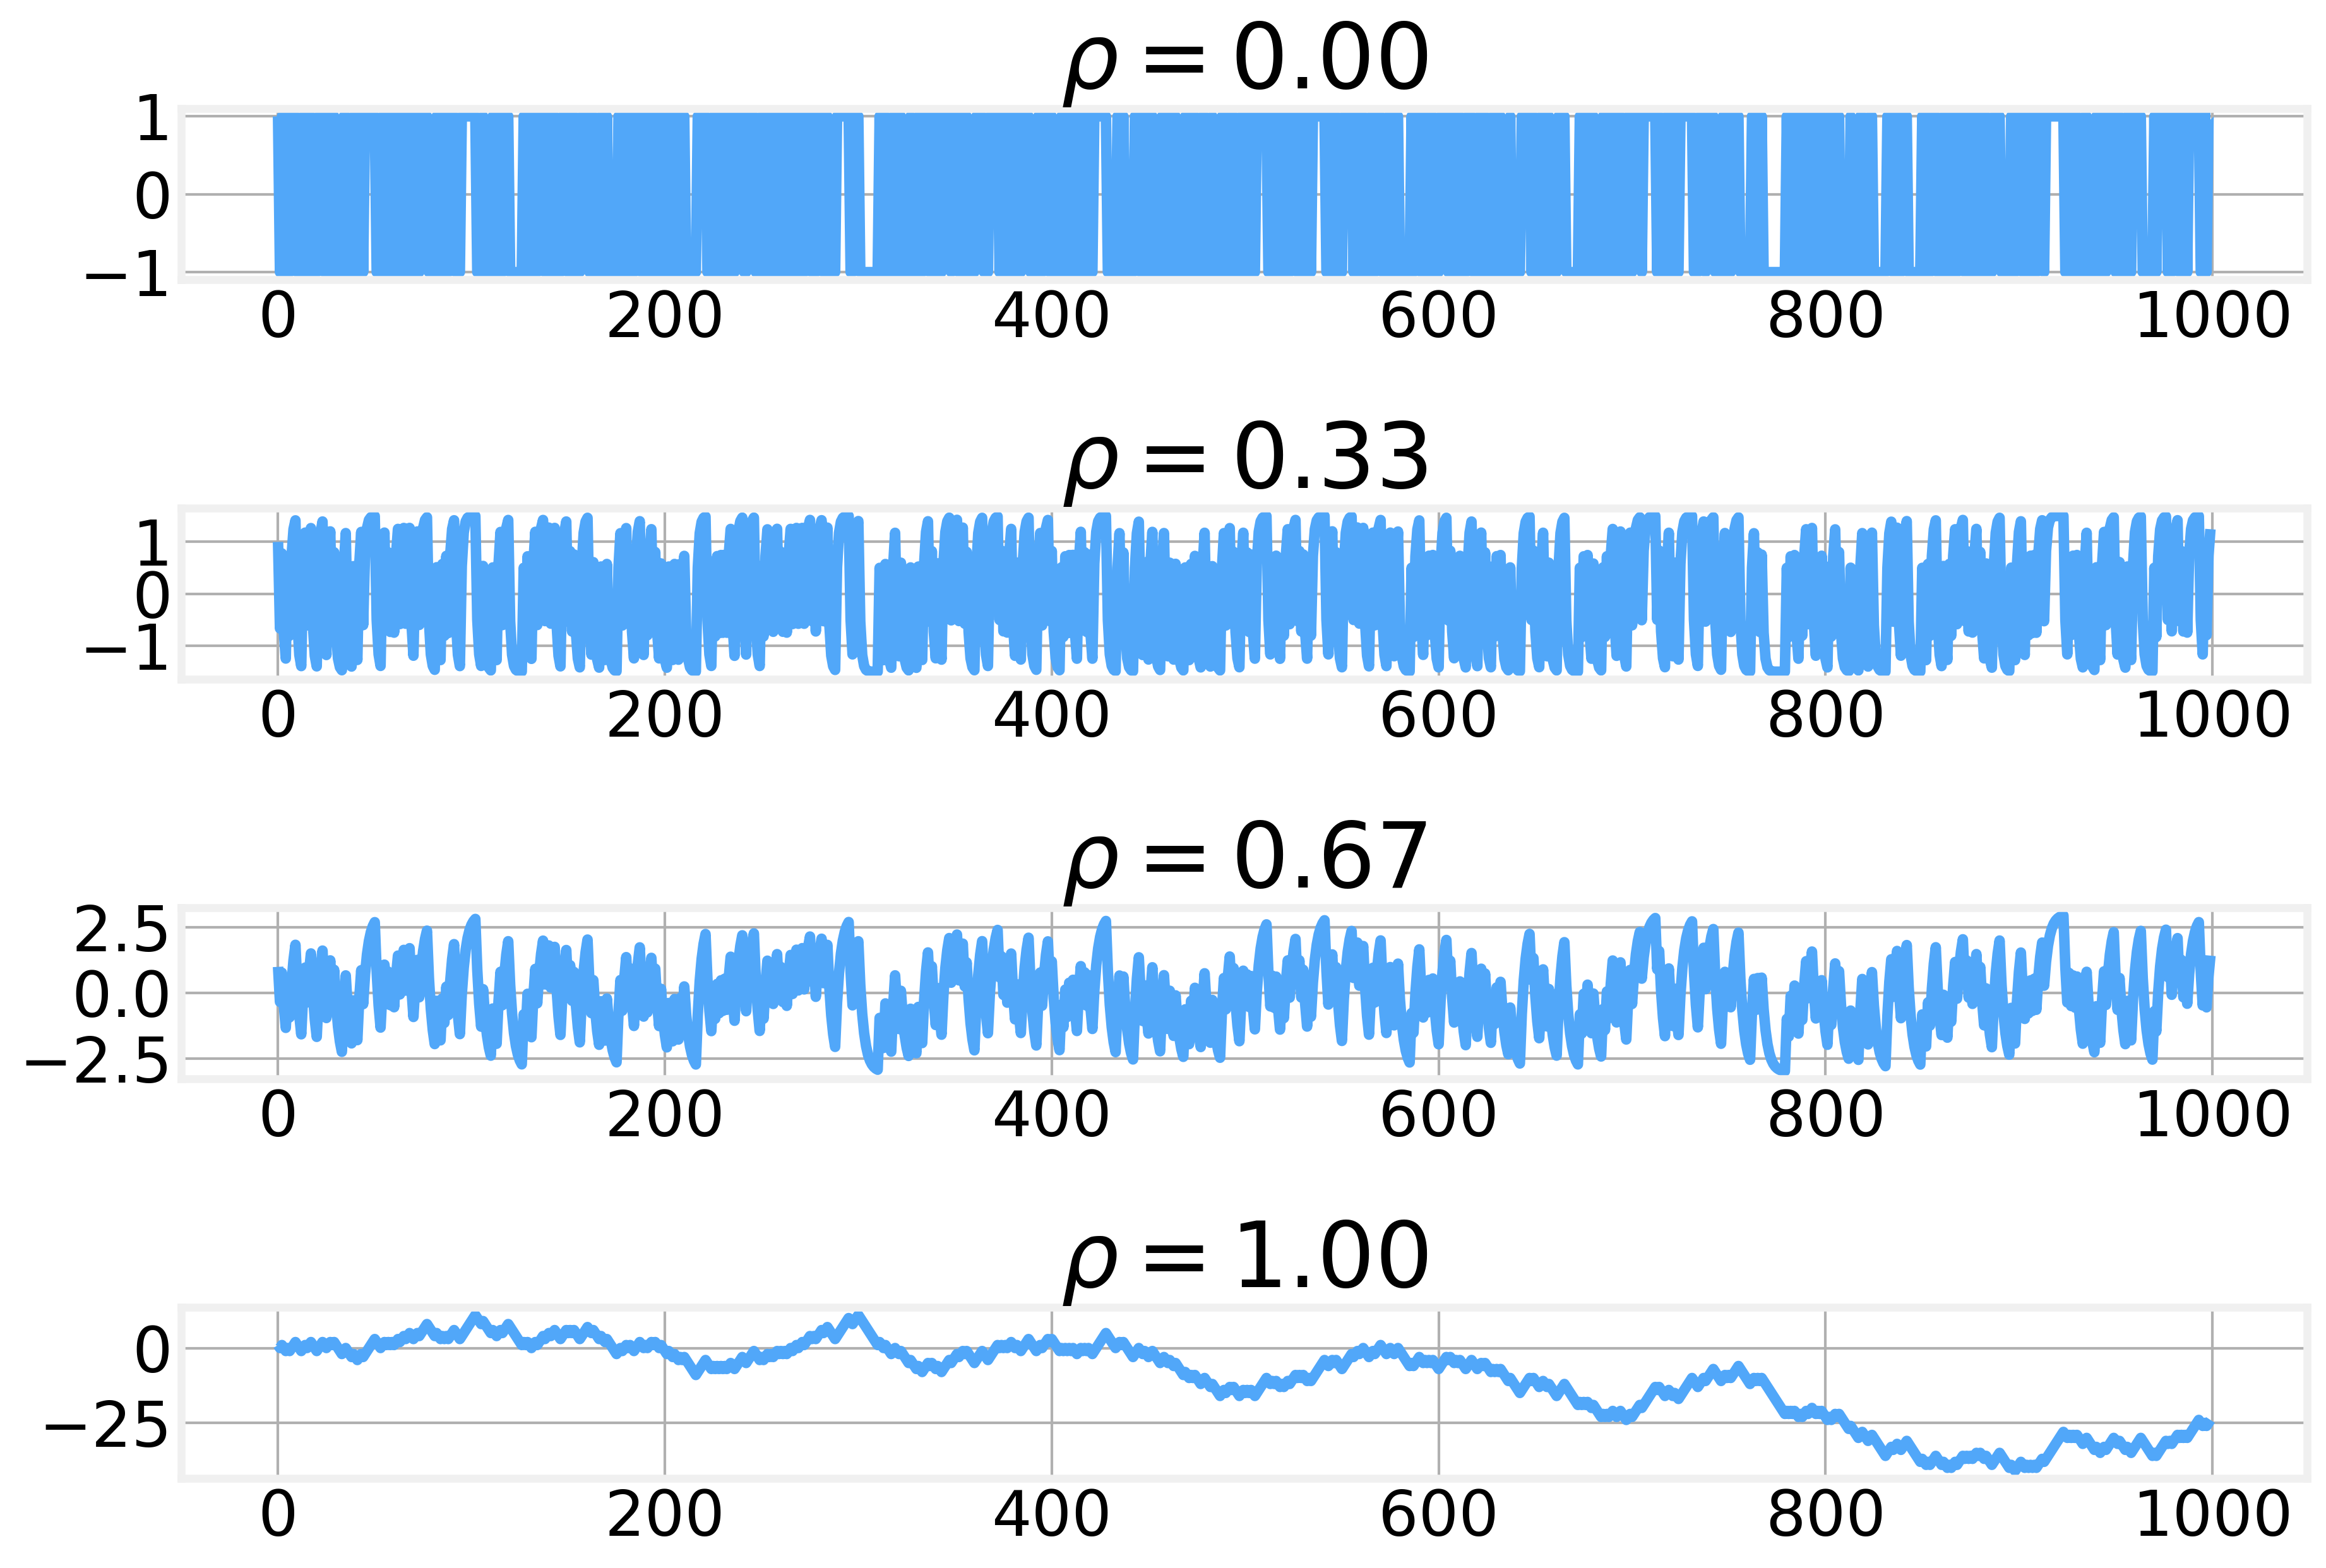

In [19]:
n_steps = 4
rho_lst = np.linspace(0, 1, n_steps)
steps = flip_coin(1, 1000)

fig, axs = plt.subplots(n_steps, 1)

for i, rho in enumerate(rho_lst):
    position = position_rho(steps, rho)
    axs[i].plot(position)
    axs[i].set_title(r'$\rho=%1.2f$' % rho)

fig.tight_layout()

The Dicky-Fuller test uses the first differences so we reintroduce the differentiate function defined before

In [20]:
def differentiate(values, d=1):
    # First value is required so that we can recover the original values with np.cumsum
    x = np.concatenate([[values[0]], values[1:]-values[:-1]])

    if d == 1:
        return x
    else:    
        return difference(x, d - 1)

A simple version of the test simply returns the slope of the fit

In [18]:
def dftest(values):
    N = len(values)
    diff = differentiate(values)

    lm = LinearRegression()
    lm.fit(values[:-1], diff[1:])
    
    return lm.coef_

The more different from zero it is the more strongly we can be sure that the process is stationary

In [19]:
position = position_rho(steps, 0)
dftest(position)

array([[-0.98841522]])

In [20]:
position = position_rho(steps, 0.8)
dftest(position)

array([[-0.20282609]])

In [21]:
position = position_rho(steps, 1.0)
dftest(position)

array([[-0.00281202]])

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>